# Testing bias metrics and mitigation algorithms on the Adult Income dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from numpy.random import default_rng
from collections import OrderedDict
from copy import deepcopy
sns.set_theme(style='darkgrid')

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover

In [2]:
# utility functions
def compute_dataset_fairness_metrics(data: BinaryLabelDataset, unpriv_group: list, priv_group: list):
    """ Computes: Disparate Impact and Statistical Parity """
    
    b = BinaryLabelDatasetMetric(data, unprivileged_groups=unpriv_group, privileged_groups=priv_group)
    metrics = dict()
    metrics['Disparate Impact'] = b.disparate_impact()
    metrics['Statistical Parity'] = b.statistical_parity_difference()
    for k in metrics:
        print("%s = %.4f" % (k, metrics[k]))
    return metrics

def compute_fairness_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Computes: Balanced Accuracy 
    Statistical Parity Difference
    Disparate Impact
    Average odds difference
    Equal Opportunity Difference
    Theil Index """
    
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

def compute_quality_metrics(dataset_true, dataset_pred, unprivileged_group, privileged_group):
    clm = ClassificationMetric(dataset_true, dataset_pred, unprivileged_group, privileged_group)
    p_metrics = OrderedDict()
    u_metrics = OrderedDict()
    p_metrics['Precision'] = clm.precision(privileged=True)
    p_metrics['Recall'] = clm.recall(privileged=True)
    p_metrics['F1 Score'] = (2*p_metrics['Precision']*p_metrics['Recall'])/(p_metrics['Precision']+p_metrics['Recall'])
    
    u_metrics['Precision'] = clm.precision(privileged=False)
    u_metrics['Recall'] = clm.recall(privileged=False)
    u_metrics['F1 Score'] = (2*u_metrics['Precision']*u_metrics['Recall'])/(u_metrics['Precision']+u_metrics['Recall'])
    return p_metrics, u_metrics

def load_dataset():
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation','relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    adult_df = pd.read_csv('adult/adult.data', names=column_names)
    adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (adult_df['race'] != ' White')].index,inplace=True)
    adult_df.loc[adult_df['native-country'] == ' ?', 'native-country'] = 'Not known'
    return adult_df

def split_data(data: BinaryLabelDataset):
    #data = BinaryLabelDataset(df=data, label_names=label_names, protected_attribute_names=protect_attr_names)
    data_train, data_tv = data.split([0.7], shuffle=True)
    data_test, data_valid = data_tv.split([0.5], shuffle=True)
    return data_train, data_test, data_valid

def x_y_split(train, test, sensitive_attributes=[]):
    x_train = train.features
    x_test = test.features
    y_train = train.labels.ravel()
    y_test = test.labels.ravel()
    for s in sensitive_attributes:
        x_train = np.delete(train.features, train.feature_names.index(s), axis=1)
        x_test = np.delete(test.features, test.feature_names.index(s), axis=1)
    return x_train, y_train, x_test, y_test

def compute_classification_metrics(estimator: Pipeline, valid_data: BinaryLabelDataset):
    
    """"Computes the bias classification metrics 
    in addition to the classification report and a confusion matrix"""
    pred = valid_data.copy()
    pred.labels = estimator.predict(pred.features)
    plot_classification_report(classification_report(valid_data.labels, pred.labels))
    plot_confusion_matrix(valid_data.labels, pred.labels, {'1', '0'}, normalize=True)
    class_metrics = compute_fairness_metrics(valid_data, pred, unprivileged_group, privileged_group)
    return class_metrics

def merge_datasets(datasets: dict):
    keys = list(datasets.keys())
    first_data = datasets.pop(keys[0])
    merged_metrics = pd.DataFrame(first_data, index=[0])
    merged_metrics.loc[0,'Dataset'] = keys[0]
    index = 1
    for k,v in datasets.items():
        merged_metrics = merged_metrics.append(v, ignore_index=True)
        merged_metrics.loc[index,'Dataset'] = k
        index = index + 1
    merged_data = merged_metrics.melt(id_vars='Dataset', value_name='values', var_name='metrics')
    return merged_data

In [3]:
def classify(estimator: Pipeline, data: BinaryLabelDataset, sensitive_attributes = [], show=True):
    np_data = np.hstack((data.features, data.labels))
    kf = KFold(n_splits=10, shuffle=True)
    class_metrics = []
    quality_metrics_p = []
    quality_metrics_u = []
    for train, test in kf.split(np_data):
        d_train = data.subset(train)
        d_test = data.subset(test)
        x_train, y_train, x_test, y_test = x_y_split(d_train, d_test, sensitive_attributes)
        if sensitive_attributes:
            for s in sensitive_attributes:
                d_test.features = np.delete(d_test.features, d_test.feature_names.index(s), axis=1)
        pipe = deepcopy(estimator)
        pipe.fit(x_train, y_train, logisticregression__sample_weight=d_train.instance_weights.ravel())
        pred = d_test.copy()
        pred.labels = pipe.predict(x_test)
        metric = compute_fairness_metrics(d_test, pred, unprivileged_group, privileged_group, disp=False)
        q_metric_p, q_metric_u = compute_quality_metrics(d_test, pred, unprivileged_group, privileged_group)
        quality_metrics_p.append(q_metric_p)
        quality_metrics_u.append(q_metric_u)
        class_metrics.append(metric)
    
    ris = {key: round(np.mean([metric[key] for metric in class_metrics]),4) for key in class_metrics[0]}
    q_metrics_p = {key: round(np.mean([metric[key] for metric in quality_metrics_p]),4) for key in quality_metrics_p[0]}
    q_metrics_u = {key: round(np.mean([metric[key] for metric in quality_metrics_u]),4) for key in quality_metrics_u[0]}
    q_metrics = pd.DataFrame(data=[q_metrics_p, q_metrics_u], index=['Privileged', 'Unprivileged'])
    plot_quality_metrics(q_metrics)
    if show:
        for key, val in ris.items():
            print("%s: %.4f" % (key,val))
    return ris

In [4]:
# plot functions

def plot_confusion_matrix(cm,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = {'1', '0'}
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_quality_metrics(q_metrics):
    ax = sns.heatmap(q_metrics, annot=True, cmap=plt.cm.RdBu)
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.yticks(rotation=0)
    plt.title('Classification Report')
    plt.tight_layout()
    return ax

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

def plot_metrics_comparison(bias_class_metrics, rw_class_metrics, title1='', title2=''):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    keys = list(bias_class_metrics.keys())
    vals = [float(bias_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[0])
    for k in keys:
        ax[0].text(keys.index(k), 
                   bias_class_metrics[k], 
                   round(bias_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    keys = list(rw_class_metrics.keys())
    vals = [float(rw_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[1])
    for k in keys:
        ax[1].text(keys.index(k), 
                   rw_class_metrics[k], 
                   round(rw_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    ax[0].tick_params(labelrotation=90)
    ax[0].set(title=title1)
    ax[1].tick_params(labelrotation=90)
    ax[1].set(title=title2)
    return ax

def plot_syntesis(dataset, title):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    unbias_fig = sns.barplot(data = dataset, x='metrics', y='values', hue='Dataset', ax=ax)
    plt.ylabel(ylabel='')
    plt.xlabel(xlabel='')
    plt.title(title)
    return ax

## Dataset description

The Adult Income dataset contains informations about the income of people extracted from the 1994 Census database. Prediction task is to determine whether a person makes over 50K a year. It has been shown that the dataset is bias in favor of white men and against women and people of other races.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

<!--3. **LFR**

> Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes-->

# Importing and exploring the dataset

In [5]:
adult_df = load_dataset()
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
adult_df.shape

(30940, 15)

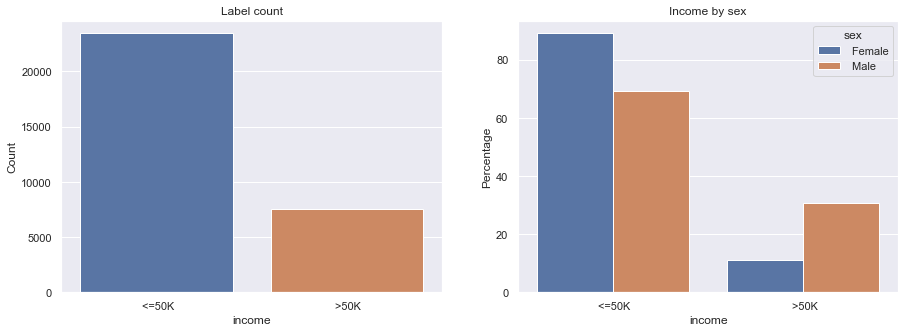

In [7]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='income', y='percentage', 
            data=adult_df[['sex','income']].groupby('sex')['income'].value_counts(normalize=True).rename('percentage').mul(100).reset_index(),
            hue='sex',
            ax=ax[1])
sns.countplot(x='income', data=adult_df, ax=ax[0])
#sns.barplot(x='income', y='percentage', 
#            data=adult_df[['race','income']].groupby('race')['income'].value_counts(normalize=True).rename('percentage').mul(100).reset_index(),
#            hue='race',
#            ax=ax[1])
ax[1].set(ylabel='Percentage', title="Income by sex")
ax[0].set(ylabel='Count', title="Label count")
plt.show()

So we are in an **Unbalanced Bias Dataset** case.

## Dataset transformation

In [8]:
lab_enc = LabelEncoder()
ord_enc = OrdinalEncoder()

In [9]:
adult_df['age_class'] = pd.cut(adult_df['age'],
                               bins=[0,9,19,29,39,49,59,69,99],
                               labels=['age<10','age between 10 and 20','age between 20 and 30',
                                       'age between 30 and 40','age between 40 and 50',
                                       'age between 50 and 60','age between 60 and 70','age>70']
                              )
adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                               bins=[0,9,19,29,39,49,99],
                               labels=['hour<10','hours between 10 and 20','hours between 20 and 30',
                                       'hours between 30 and 40','hour between 40 and 50',
                                       'hour>70']
                              )
adult_df.drop(labels=['hours-per-week','workclass','fnlwgt','capital-gain','capital-loss','age','education-num'],
              axis=1,inplace=True)
adult_df = adult_df.join(pd.get_dummies(adult_df['education'])).drop('education',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['marital-status'])).drop('marital-status',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['occupation'])).drop('occupation',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['relationship'])).drop('relationship',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['native-country'])).drop('native-country',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['age_class'])).drop('age_class',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['hour-per-week-class'])).drop('hour-per-week-class',axis=1)
adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
adult_df[['sex','race']] = ord_enc.fit_transform(adult_df[['sex','race']])

# Bias dataset and classification metrics

Create a StructuredDataset object to which apply fairness metrics and methods

In [10]:
unprivileged_group = [{'sex': 0}]
privileged_group = [{'sex': 1}]

In [11]:
data = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=adult_df, label_names=['income'], protected_attribute_names=['sex'])

In [12]:
data.feature_names

['race',
 'sex',
 ' 10th',
 ' 11th',
 ' 12th',
 ' 1st-4th',
 ' 5th-6th',
 ' 7th-8th',
 ' 9th',
 ' Assoc-acdm',
 ' Assoc-voc',
 ' Bachelors',
 ' Doctorate',
 ' HS-grad',
 ' Masters',
 ' Preschool',
 ' Prof-school',
 ' Some-college',
 ' Divorced',
 ' Married-AF-spouse',
 ' Married-civ-spouse',
 ' Married-spouse-absent',
 ' Never-married',
 ' Separated',
 ' Widowed',
 ' ?',
 ' Adm-clerical',
 ' Armed-Forces',
 ' Craft-repair',
 ' Exec-managerial',
 ' Farming-fishing',
 ' Handlers-cleaners',
 ' Machine-op-inspct',
 ' Other-service',
 ' Priv-house-serv',
 ' Prof-specialty',
 ' Protective-serv',
 ' Sales',
 ' Tech-support',
 ' Transport-moving',
 ' Husband',
 ' Not-in-family',
 ' Other-relative',
 ' Own-child',
 ' Unmarried',
 ' Wife',
 ' Cambodia',
 ' Canada',
 ' China',
 ' Columbia',
 ' Cuba',
 ' Dominican-Republic',
 ' Ecuador',
 ' El-Salvador',
 ' England',
 ' France',
 ' Germany',
 ' Greece',
 ' Guatemala',
 ' Haiti',
 ' Holand-Netherlands',
 ' Honduras',
 ' Hong',
 ' Hungary',
 ' India

### Dataset metrics

In [13]:
metrics = compute_dataset_fairness_metrics(data, unprivileged_group, privileged_group)

Disparate Impact = 0.3561
Statistical Parity = -0.1982


### Classification metrics

Balanced accuracy: 0.8123
Statistical parity difference: -0.3548
Disparate impact: 0.2834
Average odds difference: -0.2221
Equal opportunity difference: -0.1936
Theil index: 0.0824


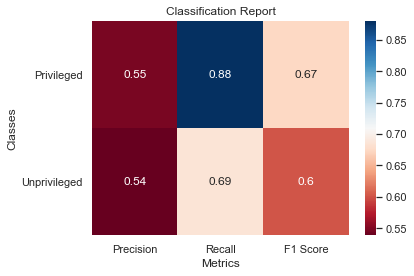

In [14]:
class_metrics = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), data)

## Reweighing

In [15]:
rw_data = data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

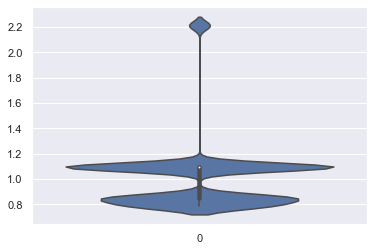

In [16]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [17]:
metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classificatiom metrics

Balanced accuracy: 0.7991
Statistical parity difference: -0.0647
Disparate impact: 0.8340
Average odds difference: -0.0332
Equal opportunity difference: 0.0274
Theil index: 0.0902


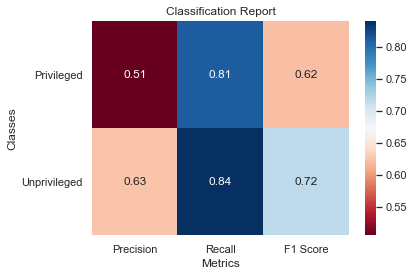

In [18]:
rw_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear', n_jobs=-1)), rw_data)

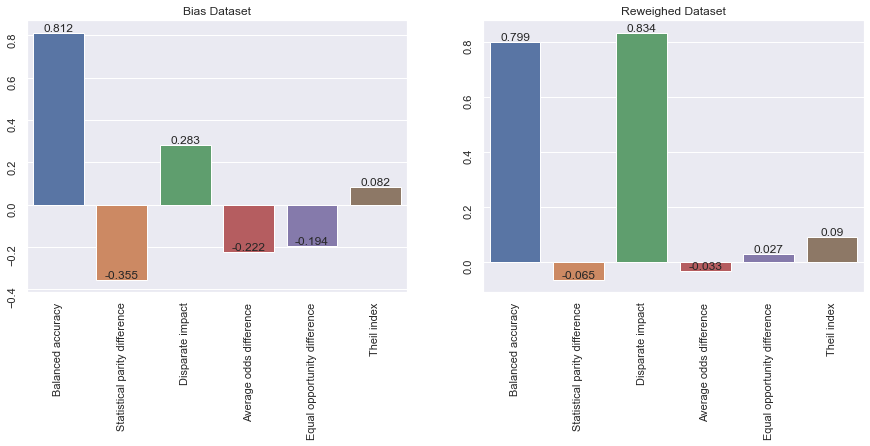

In [19]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact Remover

First we will apply the DIR to the One Hot Encoded dataset and see if it has some effects on the bias mitigation

In [135]:
dir_data = data.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


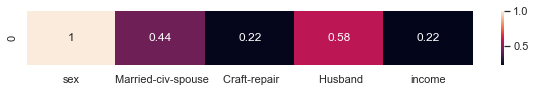

In [136]:
df = dir_data.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


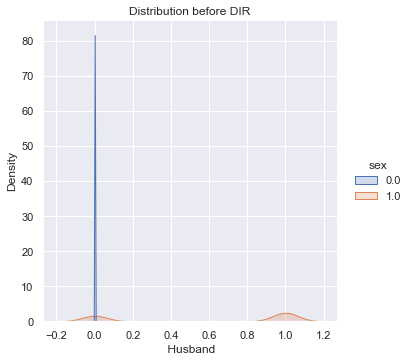

In [143]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.show()

Apply DIR and check correlation changes:

In [138]:
di = DisparateImpactRemover(sensitive_attribute='sex')
dir_data_trans = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


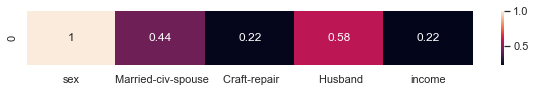

In [139]:
df = dir_data_trans.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


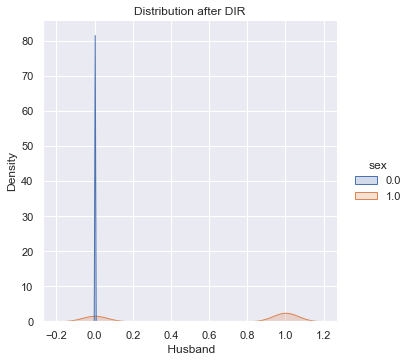

In [142]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
plt.show()

### Dataset Metrics

In [119]:
metrics = compute_dataset_fairness_metrics(dir_data, unprivileged_group, privileged_group)

Disparate Impact = 0.3561
Statistical Parity = -0.1982


Balanced accuracy: 0.8111
Statistical parity difference: -0.3153
Disparate impact: 0.3494
Average odds difference: -0.1663
Equal opportunity difference: -0.1164
Theil index: 0.0826


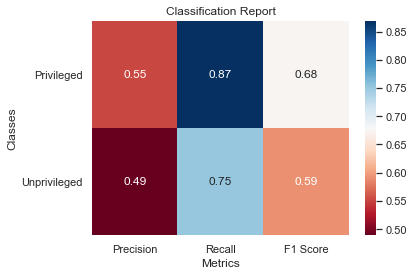

In [120]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


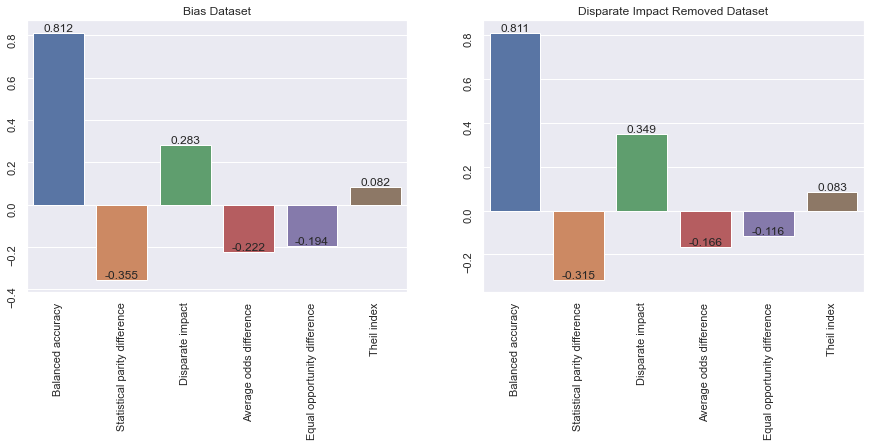

In [121]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

### Test DIR with numerical orderable data

In [195]:
df = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'native-country','race']
df.drop(df[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['income'] = le.fit_transform(df['income'])
df

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income
0,39,13,1,2174,0,40,0
1,50,13,1,0,0,13,0
2,38,9,1,0,0,40,0
3,53,7,1,0,0,40,0
4,28,13,0,0,0,40,0
...,...,...,...,...,...,...,...
32556,27,12,0,0,0,38,0
32557,40,9,1,0,0,40,1
32558,58,9,0,0,0,40,0
32559,22,9,1,0,0,20,0


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


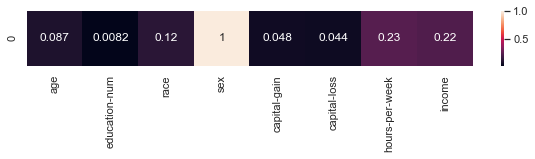

In [163]:
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


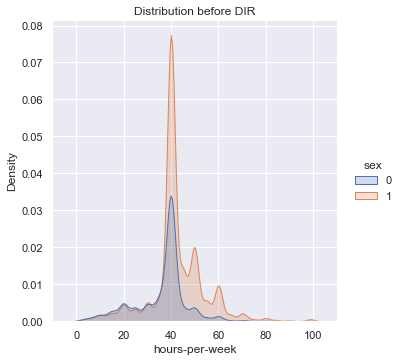

In [164]:
sns.displot(data=df, x='hours-per-week', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.show()

In [165]:
df_bin = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=df, label_names=['income'], protected_attribute_names=['sex'])
df_dir = df_bin.copy()
scaler = MinMaxScaler(copy=False)
df_dir.features = scaler.fit_transform(df_bin.features)

In [166]:
di = DisparateImpactRemover(sensitive_attribute='sex')
df_dir = di.fit_transform(df_bin)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


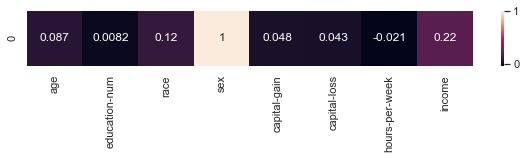

In [167]:
df = df_dir.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


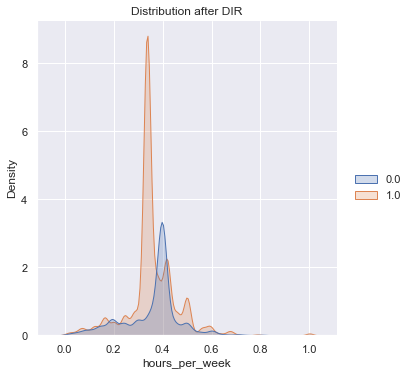

In [171]:
ax = sns.displot(x=df_dir.features[:,6], hue=df_dir.features[:,3], kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
ax.set(xlabel='hours_per_week')
plt.show()

Balanced accuracy: 0.7344
Statistical parity difference: -0.0751
Disparate impact: 0.8028
Average odds difference: 0.0053
Equal opportunity difference: -0.0143
Theil index: 0.1212


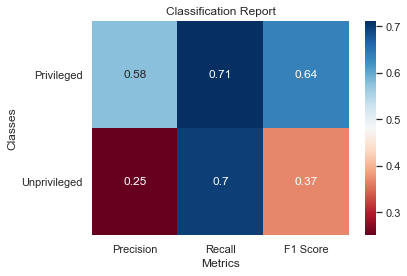

In [159]:
dir_ord_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                         df_dir, sensitive_attributes=['sex'])

Classification of new version of bias dataset

Balanced accuracy: 0.7615
Statistical parity difference: -0.3613
Disparate impact: 0.2393
Average odds difference: -0.3092
Equal opportunity difference: -0.3643
Theil index: 0.1086


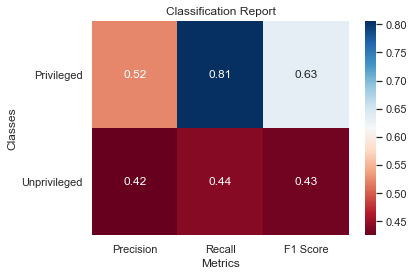

In [160]:
df_ord_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                        df_bin)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


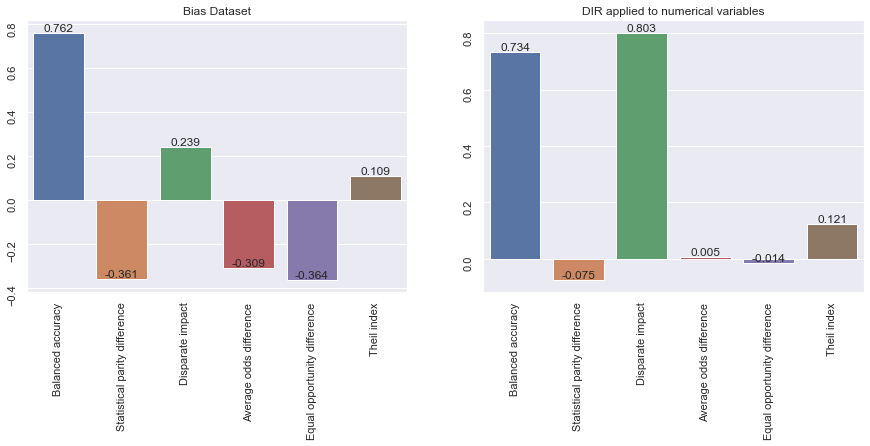

In [161]:
plot_metrics_comparison(df_ord_class, dir_ord_class, 'Bias Dataset', 'DIR applied to numerical variables')
plt.show()

## Reweighing + DIR

### Dataset with One Hot Encoded attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


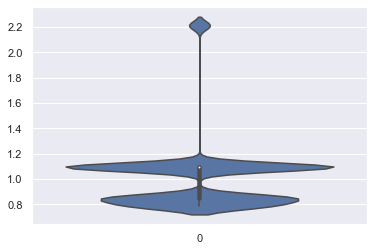

In [181]:
rw_dir_enc = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_dir_enc = rw.fit_transform(rw_dir_enc)
sns.violinplot(data=rw_dir_enc.instance_weights)
plt.show()

In [182]:
metrics = compute_dataset_fairness_metrics(rw_dir_enc, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.8006
Statistical parity difference: -0.0876
Disparate impact: 0.7800
Average odds difference: -0.0570
Equal opportunity difference: 0.0029
Theil index: 0.0885


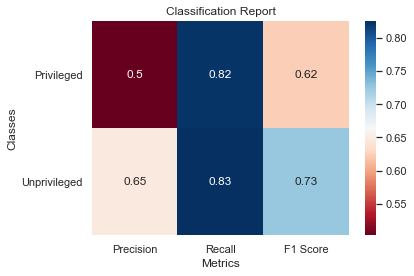

In [183]:
rw_dir_enc_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            rw_dir_enc, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


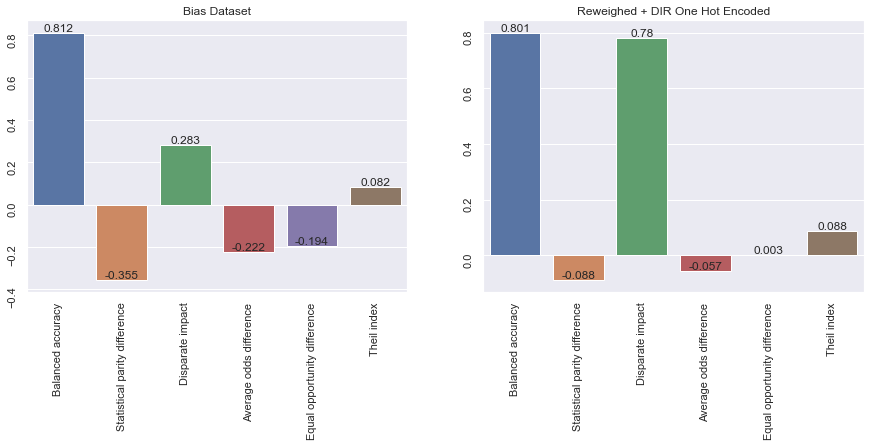

In [185]:
plot_metrics_comparison(class_metrics, rw_dir_enc_score, 'Bias Dataset', 'Reweighed + DIR One Hot Encoded')
plt.show()

### Dataset with numerical attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


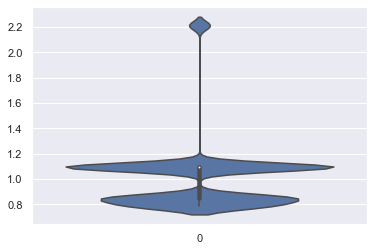

In [187]:
rw_dir_data = df_dir.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_dir_data = rw.fit_transform(rw_dir_data)
sns.violinplot(data= rw_dir_data.instance_weights)
plt.show()

In [188]:
metrics = compute_dataset_fairness_metrics(rw_dir_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7342
Statistical parity difference: 0.0197
Disparate impact: 1.0576
Average odds difference: 0.0110
Equal opportunity difference: -0.0066
Theil index: 0.1217


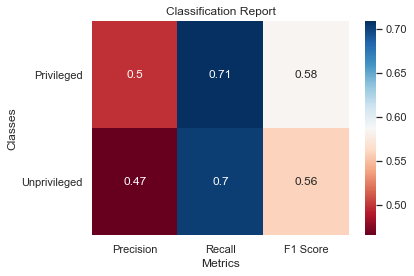

In [189]:
rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                        rw_dir_data, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


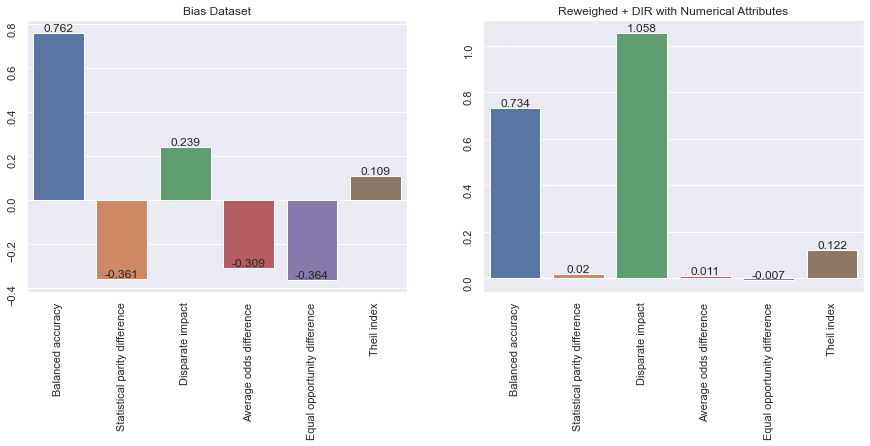

In [193]:
plot_metrics_comparison(df_ord_class, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR with Numerical Attributes')
plt.show()

## Algorithms Comparison

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


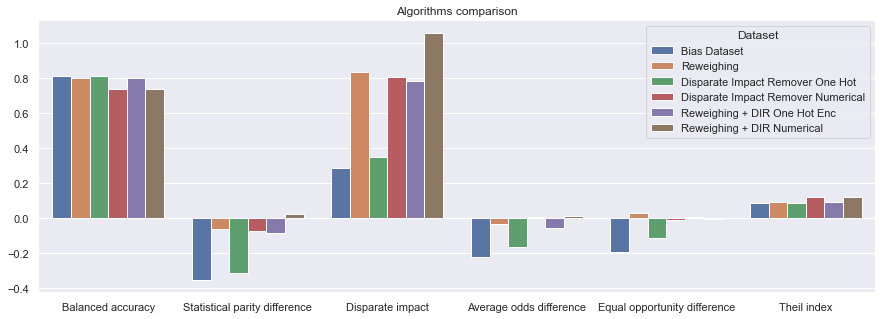

In [192]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighing': rw_class,
    'Disparate Impact Remover One Hot': dir_class,
    'Disparate Impact Remover Numerical': dir_ord_class,
    'Reweighing + DIR One Hot Enc': rw_dir_enc_score,
    'Reweighing + DIR Numerical': rw_dir_score
}), 'Algorithms comparison')
plt.show()